In [2]:
import CommonFunc
import pandas as pd

df = pd.read_csv('resources/CO2Emissions_Canada.csv')


In [3]:
from sklearn.preprocessing import LabelEncoder

#удаляем дубликаты
df.drop_duplicates()

#выделяем числовые данные
numdata = pd.DataFrame(df[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 
                           'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)',
                           'CO2 Emissions(g/km)']])

# Делаем энкодинг для категориальных признаков
label_encoder_1 = LabelEncoder()
label_encoder_2 = LabelEncoder()
label_encoder_3 = LabelEncoder()

vehicle_class = df[['Vehicle Class']].values.ravel()
fuel_type = df[['Fuel Type']].values.ravel()
transmission = df[['Transmission']].values.ravel()

encoded_vehicle_class = label_encoder_1.fit_transform(vehicle_class)
encoded_fuel_type = label_encoder_2.fit_transform(fuel_type)
encoded_transmission = label_encoder_3.fit_transform(transmission)

enc_1 = dict(zip(label_encoder_1.classes_,range(len(label_encoder_1.classes_))))
enc_2 = dict(zip(label_encoder_2.classes_,range(len(label_encoder_2.classes_))))
enc_3 = dict(zip(label_encoder_3.classes_,range(len(label_encoder_3.classes_))))

print(CommonFunc.printDict(enc_1))
print(CommonFunc.printDict(enc_2))
print(CommonFunc.printDict(enc_3))

COMPACT   0
FULL-SIZE   1
MID-SIZE   2
MINICOMPACT   3
MINIVAN   4
PICKUP TRUCK - SMALL   5
PICKUP TRUCK - STANDARD   6
SPECIAL PURPOSE VEHICLE   7
STATION WAGON - MID-SIZE   8
STATION WAGON - SMALL   9
SUBCOMPACT   10
SUV - SMALL   11
SUV - STANDARD   12
TWO-SEATER   13
VAN - CARGO   14
VAN - PASSENGER   15

D   0
E   1
N   2
X   3
Z   4

A10   0
A4   1
A5   2
A6   3
A7   4
A8   5
A9   6
AM5   7
AM6   8
AM7   9
AM8   10
AM9   11
AS10   12
AS4   13
AS5   14
AS6   15
AS7   16
AS8   17
AS9   18
AV   19
AV10   20
AV6   21
AV7   22
AV8   23
M5   24
M6   25
M7   26



In [4]:
#Составляем матрицу данных X
X_ = numdata[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 
                           'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)']]
X_['Vehicle Class'] = encoded_vehicle_class
X_['Transmission'] = encoded_fuel_type
X_['Fuel Type'] = encoded_transmission
feature_names = X_.columns
X=X_.values

#Составляем и упрощаем до одномерного массива набор целевой переменной
y = numdata[['CO2 Emissions(g/km)']].values.ravel()

*****************
Метрики качества:
*****************
MAE: 1.7227044525
MSE: 7.4837478969
RMSE: 2.7356439638
R²: 0.9978242562


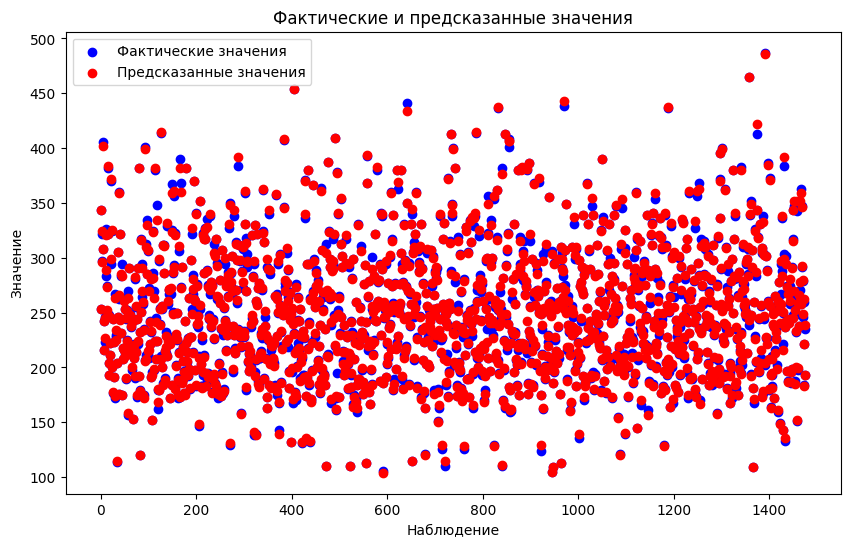

C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5\CommonFunc.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='viridis')


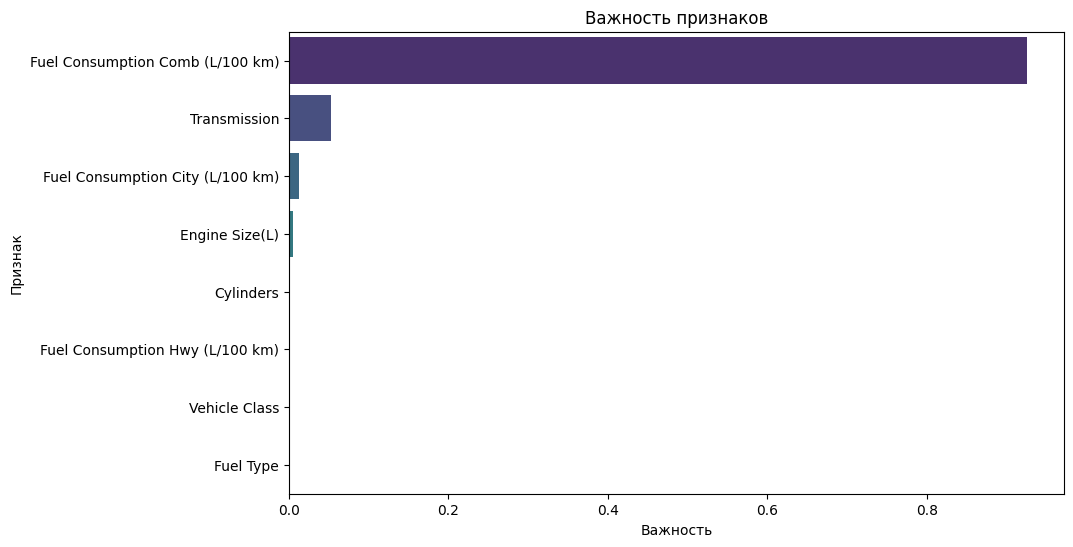

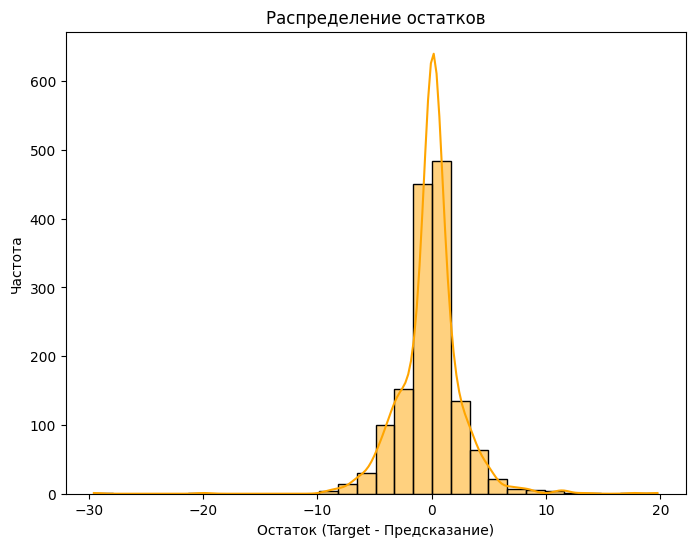

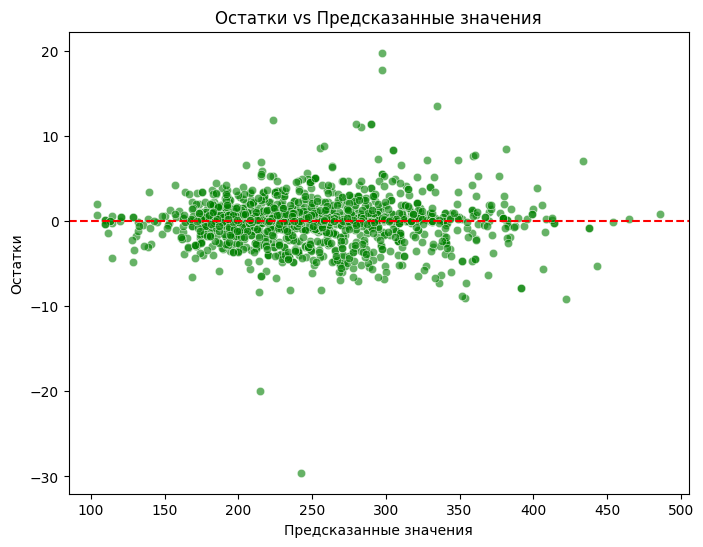

In [5]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Используем Random Forest чтобы найти наиболее важные признаки
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

rfr_metrics = CommonFunc.getMetrics(y_test, y_pred)

# Важность признаков
CommonFunc.getImportances(rfr.feature_importances_, feature_names)

# Остатки
CommonFunc.getRemains(y_test, y_pred)


In [6]:
#дропаем не влияющие на результат колонки
X_ = X_.drop(columns=['Fuel Consumption Hwy (L/100 km)', 'Fuel Type', 'Cylinders', 'Vehicle Class'])
X=X_.values

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 500}
*****************
Метрики качества:
*****************
MAE: 2.1443189965
MSE: 8.9144636179
RMSE: 2.9857099018
R²: 0.9974083055


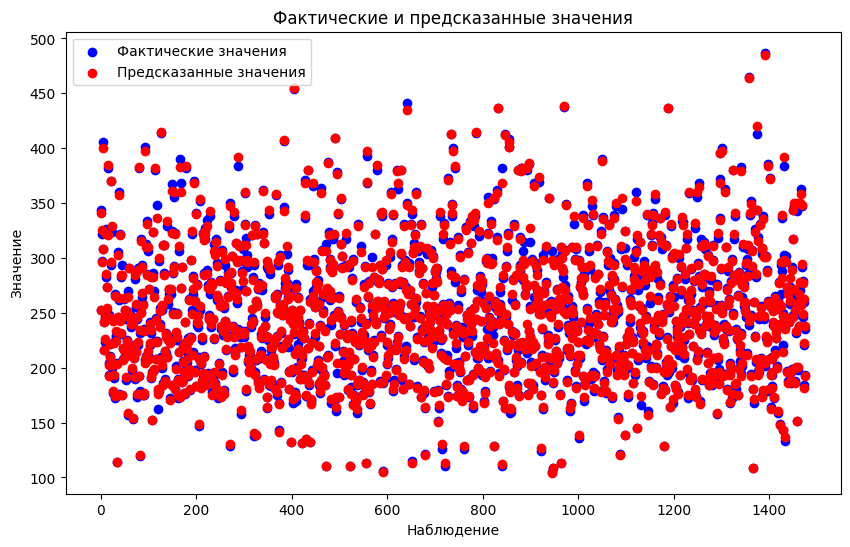

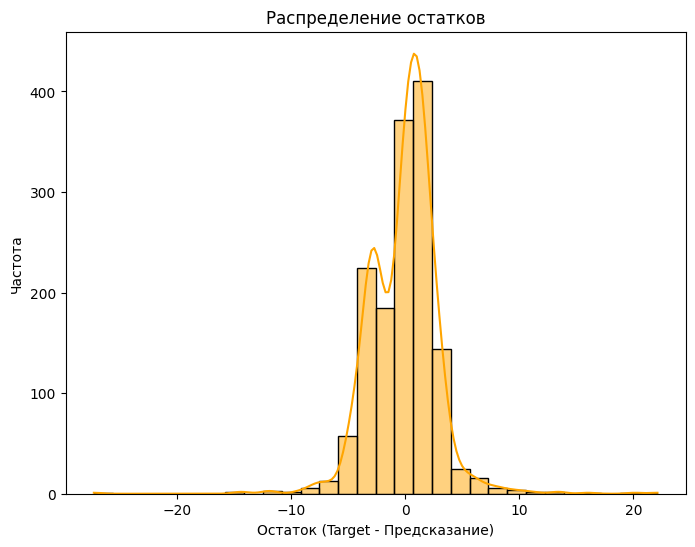

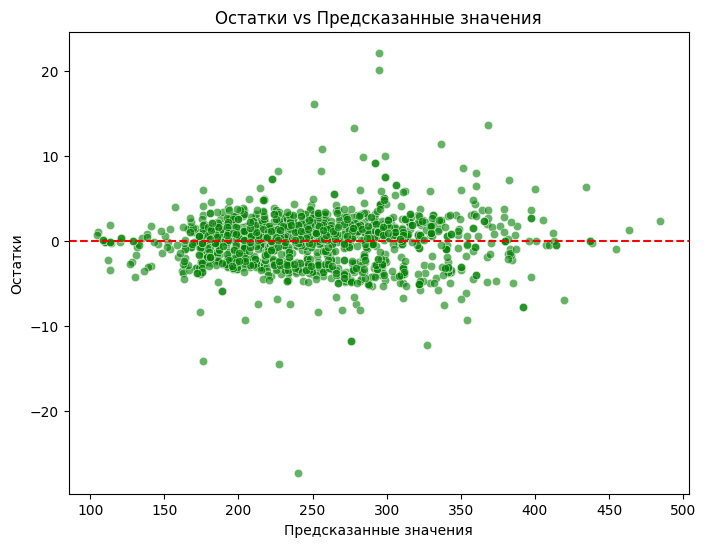

In [7]:
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor() 

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 8, 20],
    'max_features':[1, 'sqrt', 'log2'],
    'bootstrap':[True, False]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error')


grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

rfr_1 = RandomForestRegressor(**best_params) 
rfr_1.fit(X_train, y_train)
# Предсказание на тестовой выборке
y_pred = rfr_1.predict(X_test)

# Вычисление метрик
rfr_data_part_metrics = CommonFunc.getMetrics(y_test, y_pred)

CommonFunc.getRemains(y_test, y_pred)

*****************
Метрики качества:
*****************
MAE: 2.5164903901
MSE: 11.0218322054
RMSE: 3.3199144877
R²: 0.9967956319


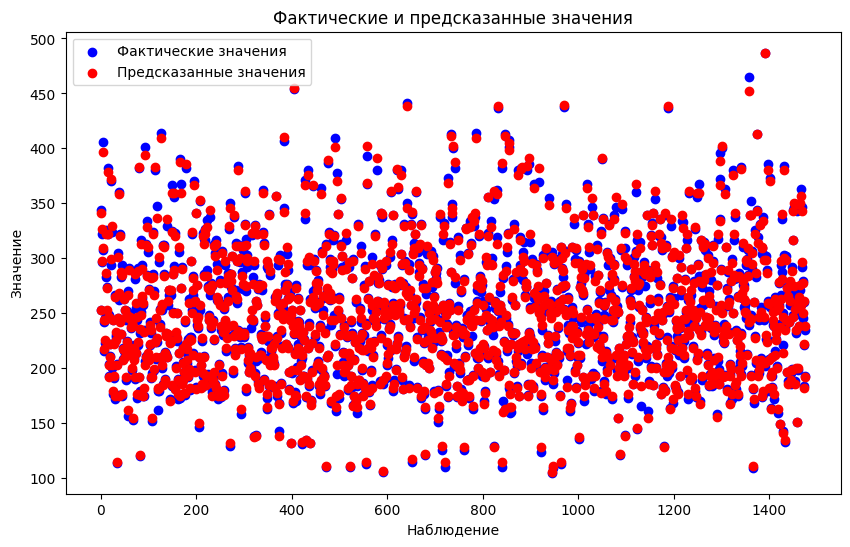

In [8]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)

gbr_metrics = CommonFunc.getMetrics(y_test, y_pred)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 398
[LightGBM] [Info] Number of data points in the train set: 5908, number of used features: 4
[LightGBM] [Info] Start training from score 250.939573
*****************
Метрики качества:
*****************
MAE: 2.2945381170
MSE: 11.9530359634
RMSE: 3.4573162950
R²: 0.9965249039


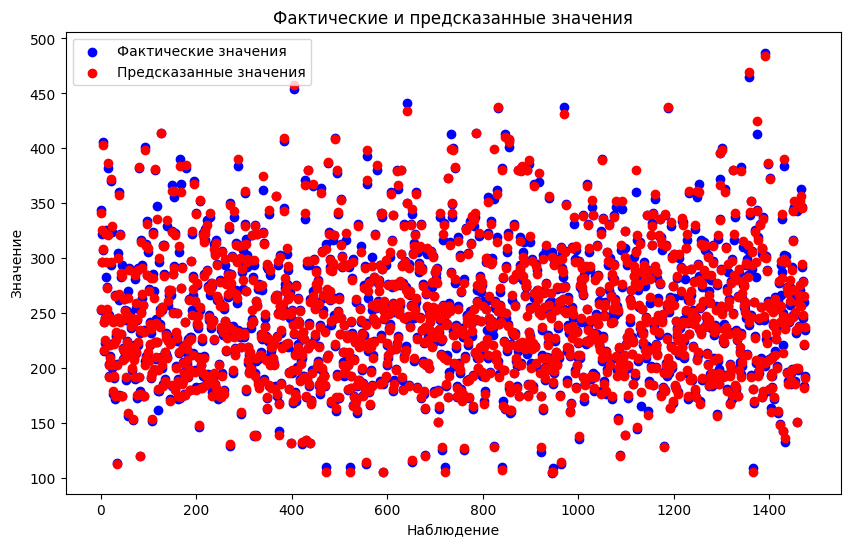

In [9]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor() # параметры
lgbm.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = lgbm.predict(X_test)

# Вычисление метрик
lgbm_metrics = CommonFunc.getMetrics(y_test, y_pred)

*****************
Метрики качества:
*****************
MAE: 2.0220564246
MSE: 8.9301945591
RMSE: 2.9883431127
R²: 0.9974037409


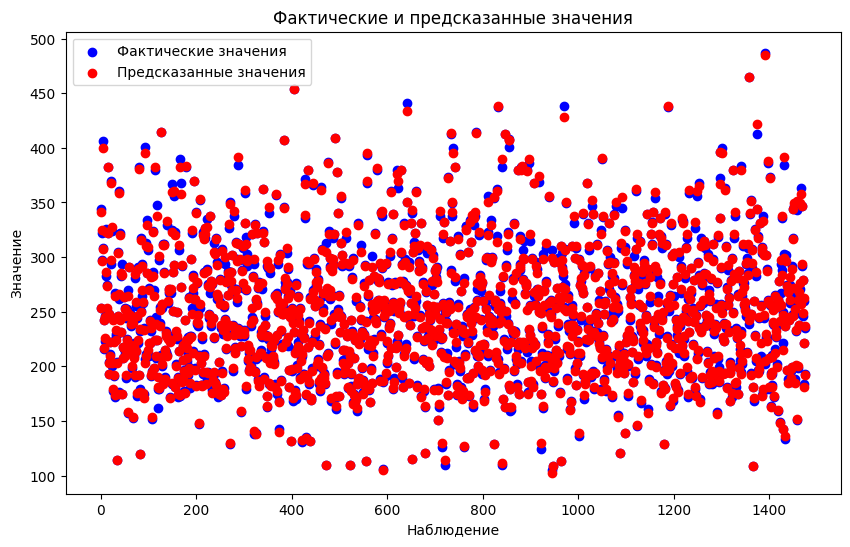

In [10]:
from xgboost import XGBRegressor

xgb = XGBRegressor() # параметры
xgb.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = xgb.predict(X_test)

# Вычисление метрик
xgb_metrics = CommonFunc.getMetrics(y_test, y_pred)

*****************
Метрики качества:
*****************
MAE: 13.1237273299
MSE: 379.1783578997
RMSE: 19.4725026101
R²: 0.8897617933


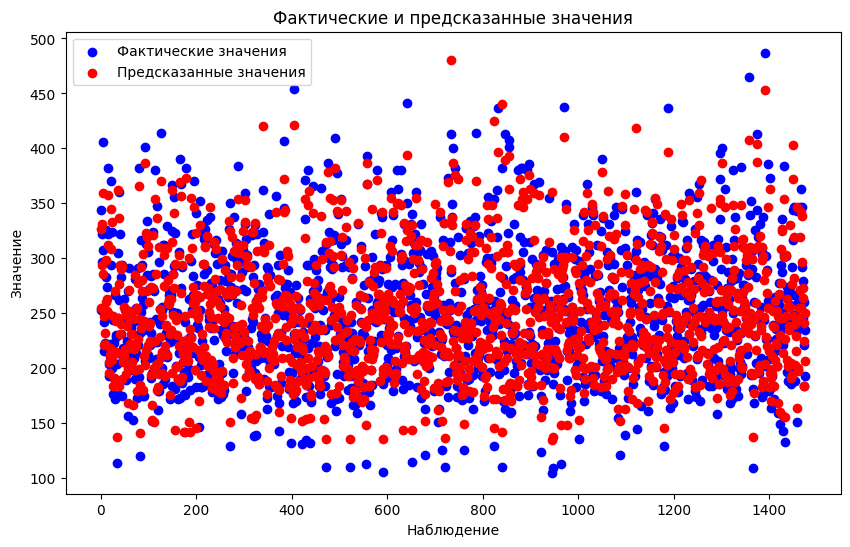

In [11]:
from sklearn.linear_model import ElasticNet

par = ElasticNet(alpha=0.2, l1_ratio=0.7, random_state=42) # параметры
par.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = par.predict(X_test)

# Вычисление метрик
par_metrics = CommonFunc.getMetrics(y_test, y_pred)


*****************
Метрики качества:
*****************
MAE: 12.9370330422
MSE: 377.2253724983
RMSE: 19.4222906089
R²: 0.8903295831


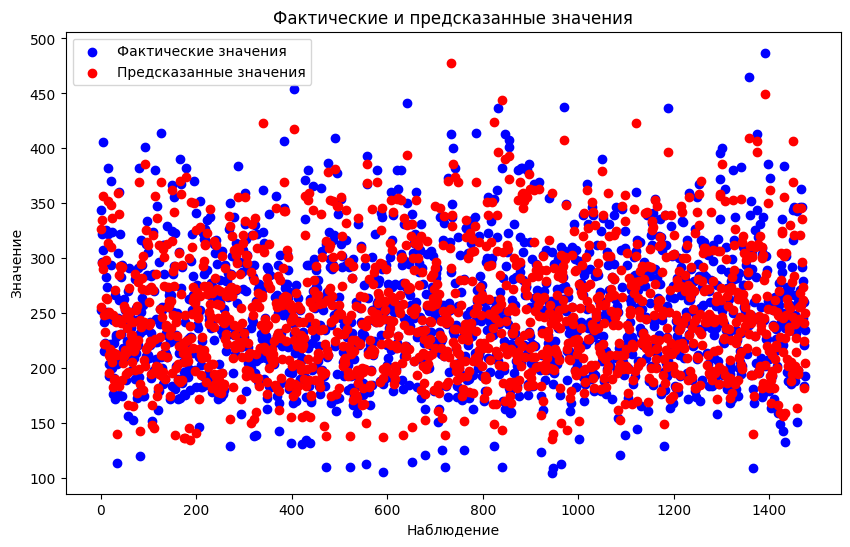

In [12]:
from sklearn.linear_model import HuberRegressor

huber = HuberRegressor(epsilon=5) # параметры
huber.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = huber.predict(X_test)

# Вычисление метрик
huber_metrics = CommonFunc.getMetrics(y_test, y_pred)

*****************
Метрики качества:
*****************
MAE: 14.2181980942
MSE: 549.5829478049
RMSE: 23.4431855302
R²: 0.8402202095


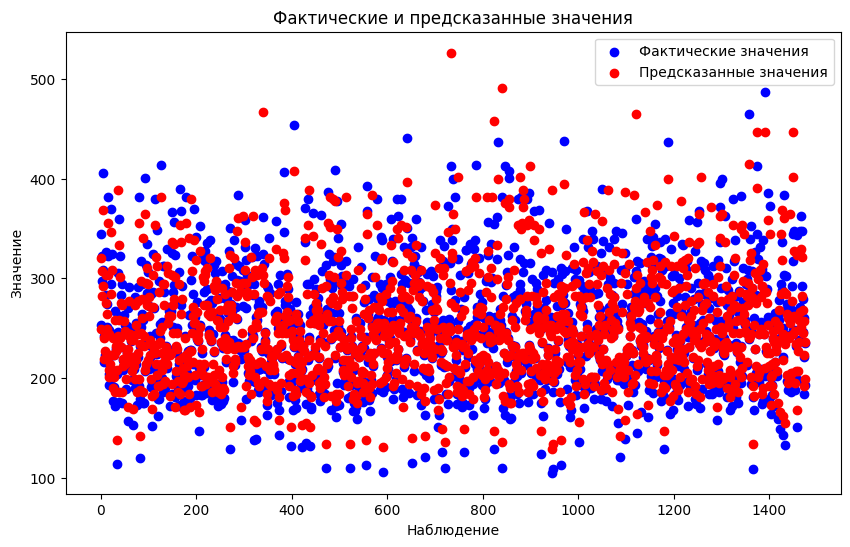

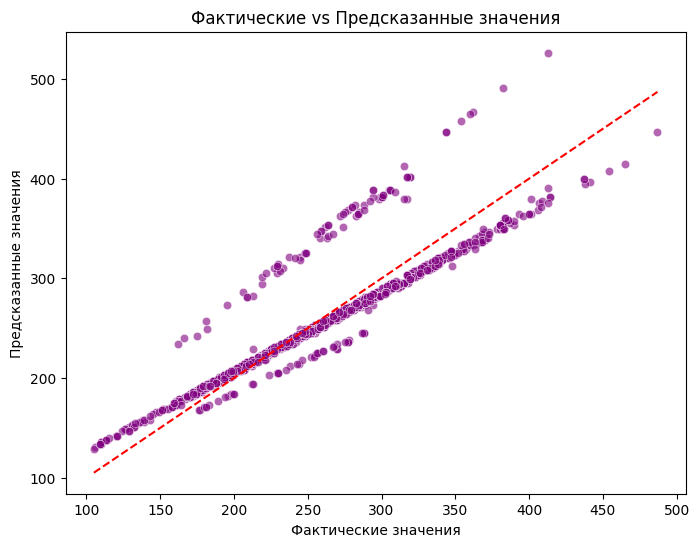

In [13]:
from sklearn.linear_model import LinearRegression
import seaborn as sns

X = numdata[['Fuel Consumption Comb (L/100 km)']]
y = numdata[['CO2 Emissions(g/km)']].values.ravel() 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor() 

lr = LinearRegression() 
lr.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = lr.predict(X_test)

# Вычисление метрик
lr_metrics = CommonFunc.getMetrics(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='purple', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Фактические vs Предсказанные значения')
plt.show()

C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5\hw5_venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
108 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5\hw5_venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5\hw5_venv\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'max_features': 1, 'min_samples_split': 20, 'n_estimators': 200}
*****************
Метрики качества:
*****************
MAE: 8.5033788749
MSE: 394.2971297809
RMSE: 19.8569164218
R²: 0.8853663254


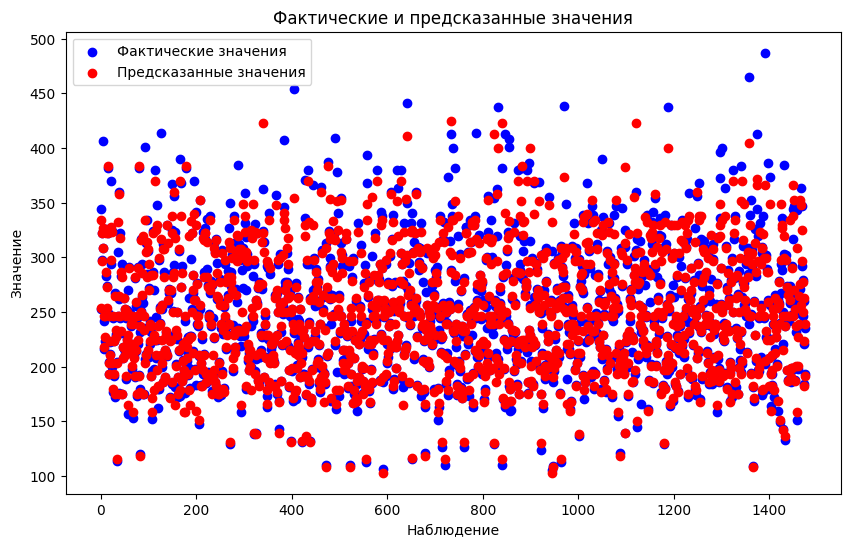

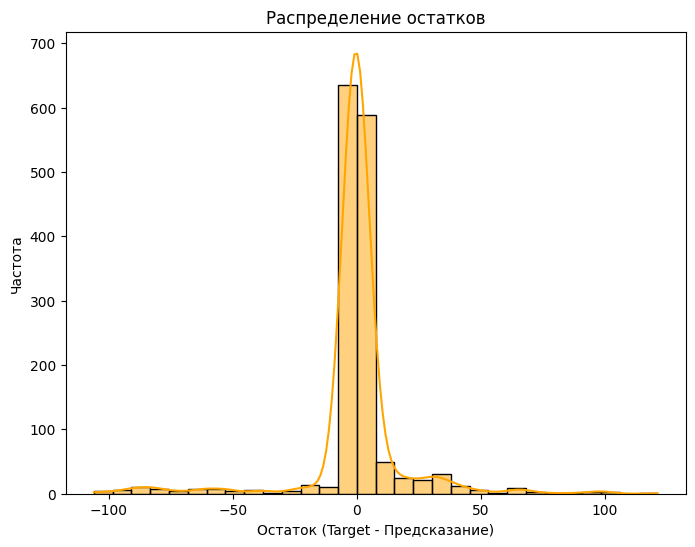

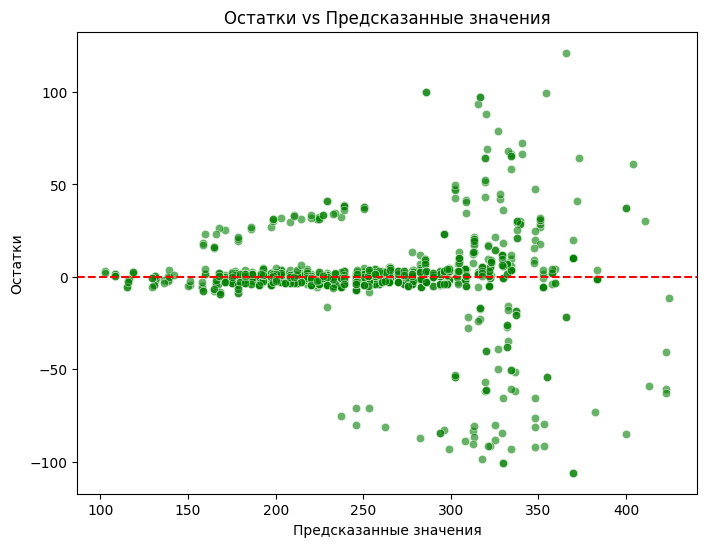

In [14]:
from sklearn.model_selection import GridSearchCV

X = numdata[['Fuel Consumption Comb (L/100 km)']]
y = numdata[['CO2 Emissions(g/km)']].values.ravel() 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor() 

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 10, 20],
    'min_samples_split': [2, 8, 20],
    'max_features':[1, 'sqrt', 'log2'],
    'bootstrap':[True, False]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error')


grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

rfr_fc = RandomForestRegressor(**best_params) 
rfr_fc.fit(X_train, y_train)
# Предсказание на тестовой выборке
y_pred = rfr_fc.predict(X_test)

# Вычисление метрик
rfr_fc_metrics = CommonFunc.getMetrics(y_test, y_pred)

CommonFunc.getRemains(y_test, y_pred)

C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5\hw5_venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
108 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5\hw5_venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5\hw5_venv\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5

Best parameters found: {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 200}
*****************
Метрики качества:
*****************
MAE: 26.0280075450
MSE: 1273.9482734875
RMSE: 35.6924119875
R²: 0.6296260845


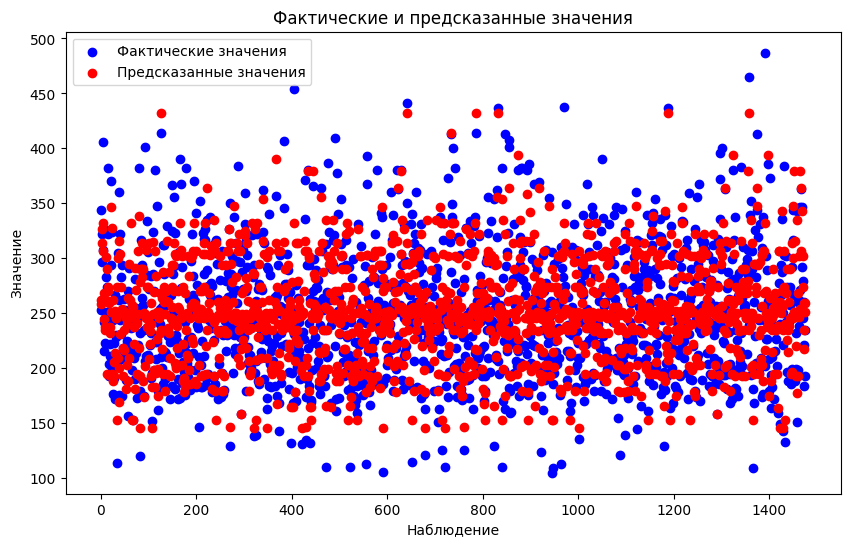

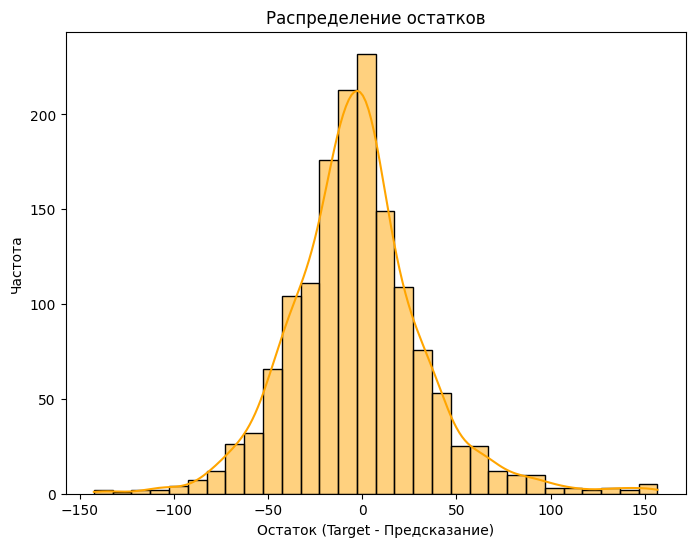

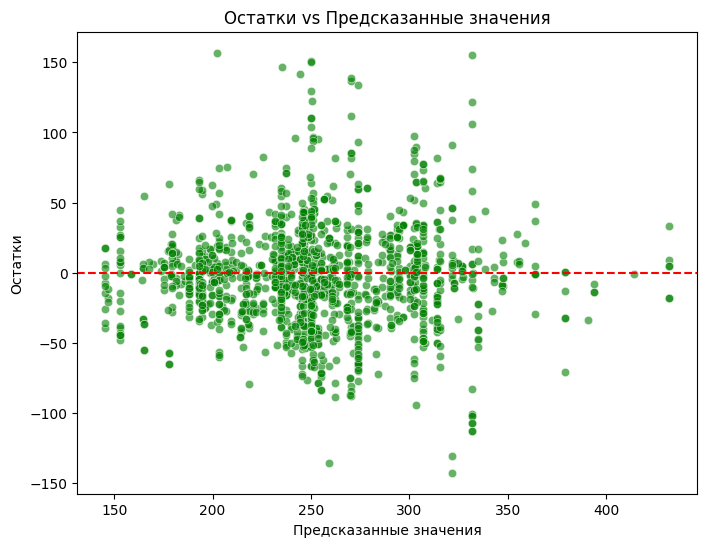

In [15]:
X = pd.DataFrame()
X['Vehicle Class'] = encoded_vehicle_class
X['Transmission'] = encoded_fuel_type
X['Fuel Type'] = encoded_transmission

y = numdata[['CO2 Emissions(g/km)']].values.ravel()

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor() 

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 10, 20],
    'min_samples_split': [2, 8, 20],
    'max_features':[1, 'sqrt', 'log2'],
    'bootstrap':[True, False]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

# Создание и обучение модели Gradient Boosting Regressor
rfr_cat = RandomForestRegressor(**best_params) # параметры
rfr_cat.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = rfr_cat.predict(X_test)

# Вычисление метрик
rfr_cat_metrics = CommonFunc.getMetrics(y_test, y_pred)

CommonFunc.getRemains(y_test, y_pred)

In [16]:
#мой автомобиль (в реальности 149 - 191 г/км)
my_y = rfr.predict(((2.0, 0, 7.3, 4.5, 6.5, 3, 0, 25),))
print(my_y) 

[162.44186905]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (9,) and arg 3 with shape (8,).

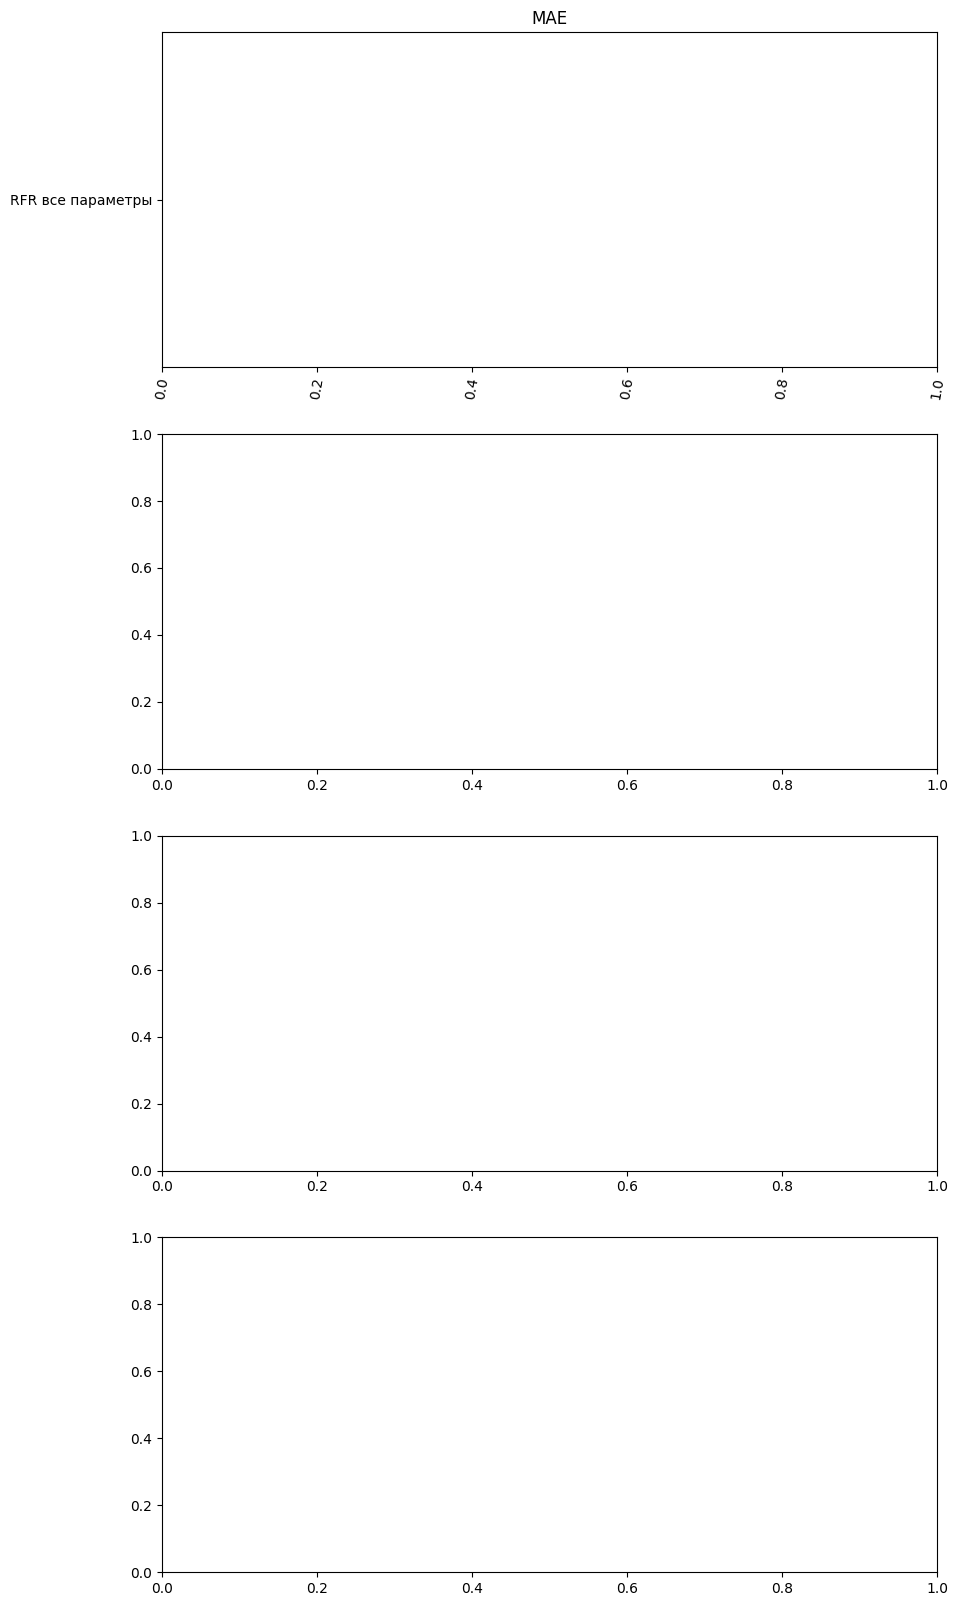

In [17]:
#Визуализация
import matplotlib.pyplot as plt

names =('RFR все параметры', 'RFR важные параметры', 'GBR важные параметры', 'LGBM важные параметры', 
        'XGB важные параметры', 'Passive Agressive', 'Huber', 'Linear regression')

mae = (rfr_metrics[0], rfr_data_part_metrics[0], gbr_metrics[0], lgbm_metrics[0], xgb_metrics[0], par_metrics[0], huber_metrics[0], lr_metrics[0], rfr_fc[0])
mse = (rfr_metrics[1], rfr_data_part_metrics[1], gbr_metrics[1], lgbm_metrics[1], xgb_metrics[1], par_metrics[1], huber_metrics[1], lr_metrics[1], rfr_fc[1])
rmse = (rfr_metrics[2], rfr_data_part_metrics[2], gbr_metrics[2], lgbm_metrics[2], xgb_metrics[2], par_metrics[2], huber_metrics[2], lr_metrics[2], rfr_fc[2])
r2 = (rfr_metrics[3], rfr_data_part_metrics[3], gbr_metrics[3], lgbm_metrics[3], xgb_metrics[3], par_metrics[3], huber_metrics[3], lr_metrics[3], rfr_fc[3])

fig, axs = plt.subplots(4, 1)
fig.set_figheight(20)
fig.set_figwidth(10)

axs[0].title.set_text('MAE')
axs[0].tick_params(axis='x', rotation=80)
axs[0].barh(names, mae)
axs[0].invert_yaxis()

axs[1].title.set_text('MSE')
axs[1].tick_params(axis='x', rotation=80)
axs[1].barh(names, mse)
axs[1].invert_yaxis()

axs[2].title.set_text('RMSE')
axs[2].tick_params(axis='x', rotation=80)
axs[2].barh(names, rmse)
axs[2].invert_yaxis()

axs[3].title.set_text('R2')
axs[3].tick_params(axis='x', rotation=80)
axs[3].barh(names, r2)
axs[3].invert_yaxis()
